In [ ]:
!nvidia-smi

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp -r gdrive/MyDrive/MOUSE_RNASeq/270K_rmbatch/MouseCellAtlas270K_rmbatch.zip ./
!cp -r gdrive/MyDrive/MOUSE_RNASeq/100K_tablusmuris/MCA100K.zip ./
!cp -r gdrive/MyDrive/HUMAN* ./
!unzip -q MouseCellAtlas270K_rmbatch.zip
!unzip -q MCA100K.zip
!mkdir MCA270K_plots
!mkdir MCA100K_plots

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace MCA100K/MCA100K_index_small.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
mkdir: cannot create directory ‘MCA270K_plots’: File exists
mkdir: cannot create directory ‘MCA100K_plots’: File exists


In [4]:
%tensorflow_version 1.x
from keras.datasets import mnist
import numpy as np
from google.colab import drive
import pandas as pd
import scipy as sp
import tables
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import seaborn as sns
sns.set(rc={'figure.figsize':(13,13)})
"""
Class to read and hold RNASeq expression data for downstream modeling
All matrcies provided are assumed to be Genes x Samples format by default
Can store data by passing either a numpy/scipy dense/sparse matrix OR read from the following formats:
    '.h5': 
        An h5 file containing sparse_csc matrix, along with genes, barcodes and shape info of expression matrix
    '.mtx': 
        A mtx file containing sparse matrix, using this option allows genes and barcodes to be provided as files
        genes and barcodes files should have 1 gene/barcode per line format
    '.tsv/.csv': 
        A tsv or csv file containing both expression, gene and barcode information
"""


class SCBox:
    
    def __init__(self, 
                 file = None, 
                 matrix = None, 
                 genes = None, 
                 barcodes = None, 
                 sample_annotation = None, 
                 gene_annotation = None, 
                 max_sp_matrix_size = 1e10):
        assert np.any(matrix) != None and np.any(genes) != None and np.any(barcodes) != None or file != None, 'Error: Either file or expression data must be provided'
        self.max_sp_matrix_size = max_sp_matrix_size
        if file != None:
            if file.endswith('.h5'):
                self._process_hdf5(file)
            elif file.endswith('.mtx') or file.endswith('.npy') or file.endswith('.npz'):
                self._process_array(file, genes, barcodes)
            elif file.endswith('.tsv') or file.endswith('.csv'):
                self._process_tsv_csv(file)
        else:
            self.matrix = matrix
            self.genes = genes
            self.barcodes = barcodes
        self.matrix = sparse.csc_matrix(self.matrix) if type(self.matrix) != type(None) else None
        self._process_s_meta(sample_annotation)
        self._process_g_meta(gene_annotation)
        self.deepModels = {}
        self.GeneSets = {}
            
    def _process_hdf5(self, file):
        f=tables.open_file(file, 'r')
        node = str(f.list_nodes('/')[0]).split('/')[1].split(' ')[0]
        mat_group = f.get_node(f.root, node)
        self.shape=getattr(mat_group, 'shape').read()
        self.genes = [g.decode() for g in getattr(mat_group, 'genes').read()]
        self.barcodes = [g.decode() for g in getattr(mat_group, 'barcodes').read()]
        if self.shape[0]*self.shape[1] <= self.max_sp_matrix_size:
            indptr=getattr(mat_group, 'indptr').read()
            data = getattr(mat_group, 'data').read()
            indices = getattr(mat_group, 'indices').read()
            self.matrix = sparse.csc_matrix((data, indices, indptr), shape=self.shape)  
        else:
            self.matrix = None
            self.h5_file = file
            
    def _process_array(self, file, genes, barcodes):
        assert genes != None and barcodes != None, 'please provide genes and barcodes as either lists or tsv files'
        if file.endswith('.mtx'):
            self.matrix = sp.io.mmread(file)
        elif file.endswith('.npy'):
            self.matrix = np.load(file)
        elif file.endswith('.npz'):
            self.matrix = sparse.load_npz(file)
        self.shape = self.matrix.shape
        self.genes = [line.rstrip().split('\t')[0] for line in open(genes)] if type(genes) == str else genes
        self.barcodes = [line.rstrip().split('\t')[0] for line in open(barcodes)] if type(barcodes) == str else barcodes
        assert len(self.genes) == self.shape[0] and len(self.barcodes) == self.shape[1], \
        'gene list provided was of len %i, barcodes provided was of len %i, while matrix was of shape %i x %i'%(len(genes), len(barcodes), self.shape[0], self.shape[1])
        
    def _process_tsv_csv(self, file):
        delim = '\t' if file.endswith('.tsv') else ','
        self.matrix = pd.read_csv(file, sep=delim, index_col = 0, header=0)
        self.genes = list(self.matrix.index)
        self.barcodes = list(self.matrix.barcodes)
        self.matrix = self.matrix.values
        self.shape = self.matrix.shape
        
    def _process_s_meta(self, s_meta):
        if s_meta == None: return 
        if type(s_meta) == str:
            s_meta = pd.read_csv(s_meta, index_col=0) if s_meta.endswith('.csv') else pd.read_csv(s_meta, index_col=0, sep='\t')
        assert set(s_meta.index) == set(self.barcodes), 'provided sample annotation does not contain all samples OR sample annotations does not have barcodes as first column of file or index of dataframe'
        self.s_meta = s_meta.reindex(self.barcodes)
        
    def _process_g_meta(self, g_meta):
        if g_meta == None: return 
        if type(g_meta) == str:
            g_meta = pd.read_csv(g_meta, index_col=0) if g_meta.endswith('.csv') else pd.read_csv(g_meta, index_col=0, sep='\t')
        assert set(g_meta.index) == set(self.genes), 'provided sample annotation does not contain all genes OR gene annotations does not have gene names as first column of file or index of dataframe'
        self.g_meta = g_meta.reindex(self.genes)
    
    def add_gene_sets(self, name, gene_set):
        """
        Args:
            name: name of geneset to add
            gene_set: npy file name of gene-set or list or numpy.ndarray of gene-set names of indices
        """
        if type(gene_set) == str and gene_set.endswith('npy'):
            gene_set = np.load(gene_set)
        assert type(gene_set) in [list, np.ndarray], 'provided gene set must be list or numpy array'
        if type(gene_set[0]) not in [np.bytes_, str]: gene_set = [int(g) for g in gene_set]
        assert type(gene_set[0]) in [int, np.bytes_, str], 'gene set must either contain gene names or gene indices'
        gene_dict = {self.genes[i]:i for i in range(len(self.genes))}
        gene_set = [g.decode() for g in gene_set] if type(gene_set[0]) == np.bytes_ else gene_set
        self.GeneSets[name] = [gene_dict[g] for g in gene_set] if type(gene_set[0]) == str else gene_set
    
    def addDeepModel(self, name, model, optimizer, gene_set = None, batchEffects = None, libFactor = 'mlp', verbose = False):
        confounders, genes2use = None, 'all'
        if batchEffects != None:
            assert type(batchEffects) == str, 'batchEffects must be string of batchEffects connected by "+"'
            batchEffects = batchEffects.split('+')
            confounders = to_categorical(pd.Categorical([str(i) for i in self.s_meta[batchEffects].values]).codes)
        if gene_set != None:
            assert type(gene_set) == str or type(gene_set) == list, 'gene_set must be name or list of previously added gene set'
            if type(gene_set) == str: gene_set = [gene_set]
            genes2use = set()
            for gs in gene_set:
                genes2use = genes2use.union(set(self.GeneSets[gs]))
            genes2use = list(genes2use)
            input_size = len(genes2use)
        else:
            genes2use = list(range(self.shape[0]))
        
        batchNum = confounders.shape[1] if np.any(confounders) != None else None
        print(batchNum)
        print(input_size)
        print(len(genes2use))
        model.construct(input_size = input_size, optimizer=optimizer, library_factor = libFactor, batch_effects = batchNum, verbose=verbose)
        self.deepModels[name] = {'Model': model, 'gene_set': genes2use}
        if type(confounders) != type(None): self.deepModels[name]['confounders'] = confounders 

    def reCompileDeepModel(self, name, optimizer, features=None):
        pass
    
    def trainDeepModel(self, name, epochs, plot_dir = None, labels = None):
        model = self.deepModels[name]['Model']
        labels = self.s_meta[labels] if labels != None else None
        if type(self.matrix) == type(None):
            hdf5_file_trainer(model = model, 
                              file = self.h5_file, 
                              epochs=epochs, 
                              confounders = self.deepModels[name]['confounders'],
                              Hgenes=self.deepModels[name]['gene_set'], 
                              plot_dir=plot_dir, 
                              labels=labels)
        else:
            X = [self.matrix[self.deepModels[name]['gene_set'], :].toarray().T]
            if 'confounders' in self.deepModels[name].keys(): X.append(self.deepModels[name]['confounders'])
            for i in range(epochs):
                model.fit(X, batch_size=128, epochs=1+i, initial_epoch=i, verbose=1, callbacks=None, shuffle=True, validate=True)
                makeLatentSpaceUMAPplot(X, model, color=labels, save_path=plot_dir+'/'+name+'epoch_'+str(i)+'_umap.jpg', title=name+'epoch_'+str(i))
            
    def convert2scanpy(self):
        pass
    
    
        

In [6]:
def readh5(file):
    f=tables.open_file(file, 'r')
    node = str(f.list_nodes('/')[0]).split('/')[1].split(' ')[0]
    mat_group = f.get_node(f.root, node)
    shape=getattr(mat_group, 'shape').read()
    genes = [g.decode() for g in getattr(mat_group, 'genes').read()]
    barcodes = [g.decode() for g in getattr(mat_group, 'barcodes').read()]
    indptr=getattr(mat_group, 'indptr').read()
    data = getattr(mat_group, 'data').read()
    indices = getattr(mat_group, 'indices').read()
    matrix = sparse.csc_matrix((data, indices, indptr), shape=shape)
    return matrix, genes, barcodes

In [9]:
import keras.backend as K
import tensorflow as tf
import numpy as np
# Likelihood Functions ( all positive likelihoods )
def bernoulli_loglikelihood(y_true, mean, eps=1e-32):
    
    loglikelihood = K.sum(y_true*K.log(mean+eps)+(1-y_true)*K.log(1-mean+eps), axis=-1)
    
    return loglikelihood


def possion_loglikelihood(y_true, lbd, eps=1e-32):
    
    loglikelihood = K.sum(y_true*K.log(lbd+eps)-lbd-tf.lgamma(y_true+1), axis=-1)
    
    return loglikelihood


def negative_binomial_loglikelihood(y_true, mean, theta, pi=0.0, pi_l2_norm=0.05, eps=1e-32):
    theta = K.minimum(theta, 1e6)
    lgamma =  tf.lgamma(y_true+theta+eps) - tf.lgamma(theta+eps) - tf.lgamma(y_true+1.0) 
    lexp = theta*K.log(theta+eps)+y_true*K.log(mean+eps)-(theta+y_true)*K.log(theta+mean+eps)
    nb_loss = lgamma + lexp
    zero_loss = K.softplus(- pi + theta * (K.log(theta + eps) - K.log(theta + mean + eps))) -\
                    K.softplus(-pi)
    zero_pos = K.cast(K.less(y_true, eps), dtype='float32')
    result = zero_loss*zero_pos + nb_loss*(1-zero_pos) - pi_l2_norm*(pi ** 2)
    return K.sum(result, axis=-1)

# assuming covariance matrix is diagonal
log2pi = np.log(2*np.pi)
#tf.constant(, dtype=tf.float32)

def multivariate_gaussian_loglikelihood(target, mu=0.0, logsigma=0.0):
    
    sigma=K.exp(logsigma)
    
    loglikelihood= - 0.5 * K.sum(((target - mu)/sigma)** 2 + 2*K.log(sigma + 1e-8)+log2pi, axis=-1)
    
    return loglikelihood

In [ ]:
mca100K.trainDeepModel('fvae_50', 2000, 'MCA100K_plots/', 'tissue')

In [ ]:
mca100K.trainDeepModel('fvae_50', 200, 'MCA100K_plots/', 'tissue')

In [ ]:
mca100K.deepModels['fvae_50']['confounders']

In [ ]:
mca100K.s_meta['tissue'].values

array(['Spleen', 'Mammary_Gland', 'Skin', ..., 'Spleen', 'Fat',
       'Limb_Muscle'], dtype=object)

In [ ]:
model_0 = mca100K.deepModels['fvae_50']['Model']

In [ ]:
facs, facs_g, facs_b = readh5('./MCA100K/MCA100K.h5')

In [ ]:
facs = facs[mca100K.deepModels['fvae_50']['gene_set'],:].toarray().T

In [ ]:
umap = model_0.latent_inference(facs, True)

In [ ]:
mca100K.s_meta

In [30]:
anno = mca100K.s_meta

In [31]:
shared_cells = set(anno.iloc[np.where(anno['protocol'] == '10X')]['cell_ontology_class']).intersection(set(anno.iloc[np.where(anno['protocol'] == 'FACS')]['cell_ontology_class']))
shared_cells_dict = Counter(anno['cell_ontology_class'][anno['cell_ontology_class'].isin(shared_cells)])
for k in list(shared_cells):
    if shared_cells_dict[k] < 2000:
        shared_cells.remove(k)

In [32]:
shared_cells

{'B cell',
 'T cell',
 'basal cell of epidermis',
 'endothelial cell',
 'fibroblast',
 'hepatocyte',
 'immature T cell',
 'keratinocyte',
 'mesenchymal cell',
 'stromal cell'}

In [ ]:
Counter(anno['cell_ontology_class'])

In [ ]:
indices = np.where(anno['cell_ontology_class'].isin(shared_cells))[0]

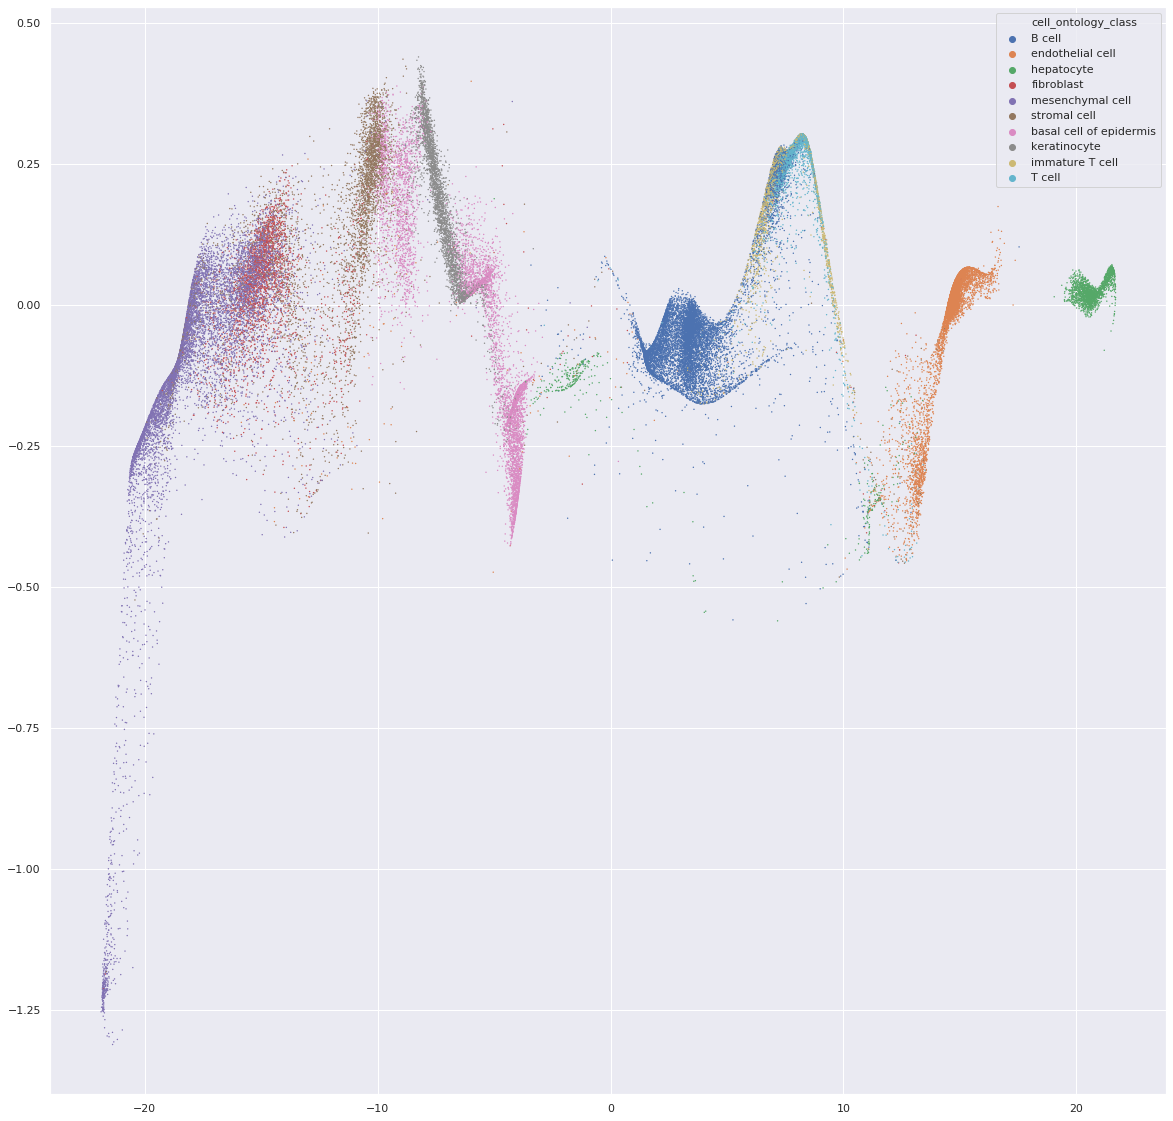

In [ ]:
sns.scatterplot(umap[indices,0], umap[indices,1], hue=anno.iloc[indices]['cell_ontology_class'], s=2,  edgecolor="none")

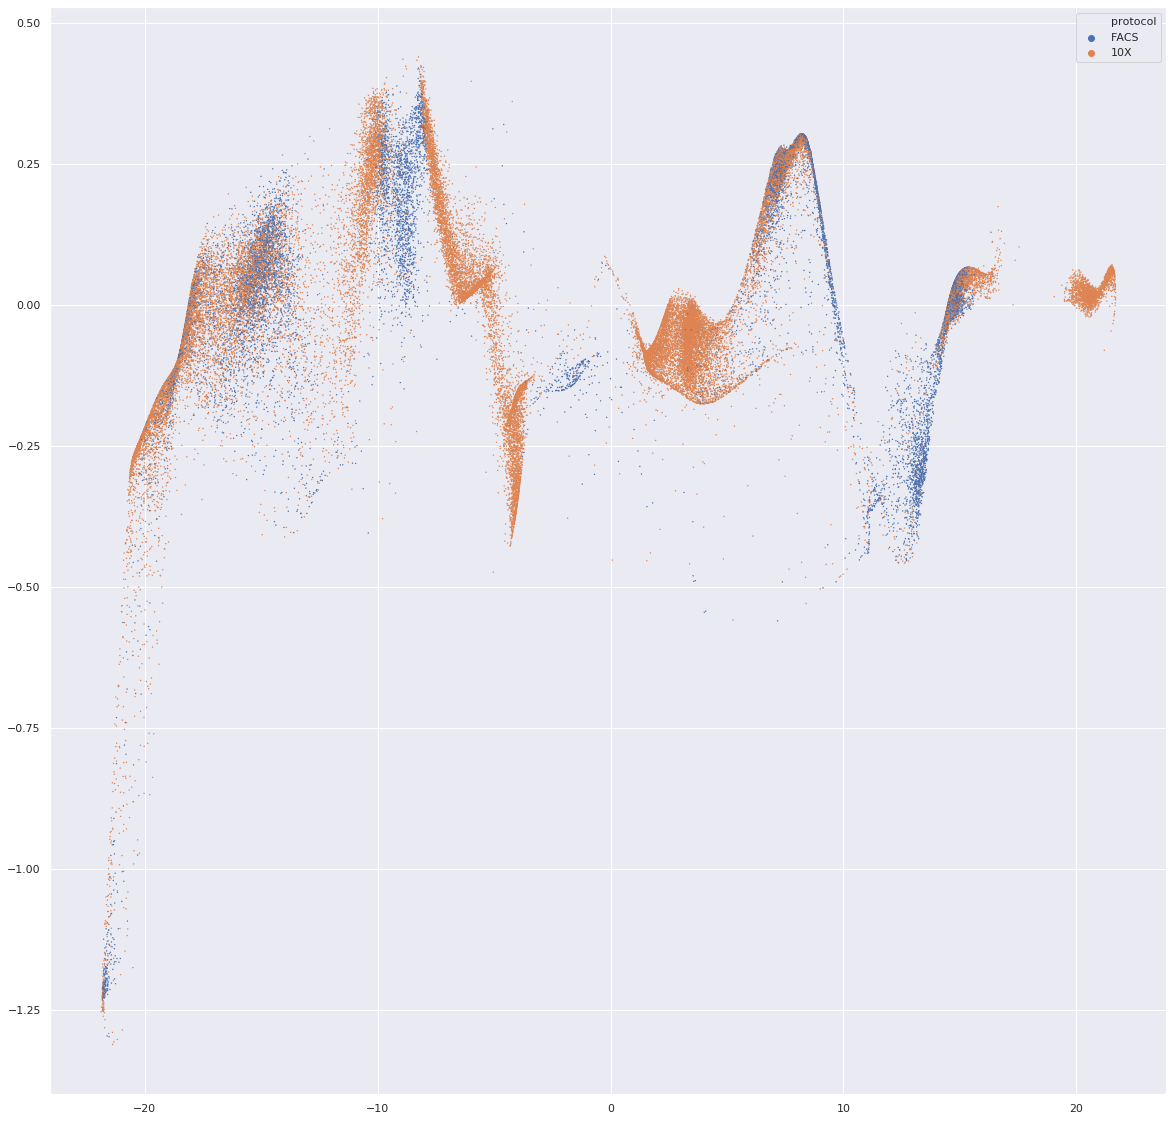

In [ ]:
sns.scatterplot(umap[indices,0], umap[indices,1], hue=anno.iloc[indices]['protocol'], s=2,  edgecolor="none")

In [ ]:
plt.scatter(umap[:,0], umap[:,1], s=0.2)

In [ ]:
pbmc68k = SCBox(file = './HUMAN_RNASeq/68KPBMC/68KPBMC.npz', genes='./HUMAN_RNASeq/68KPBMC/genes.tsv', barcodes='./HUMAN_RNASeq/68KPBMC/barcodes.tsv', sample_annotation='./HUMAN_RNASeq/68KPBMC/pbmc68k_annotations.csv')

In [26]:
from collections import Counter

In [29]:
Counter(mca100K.s_meta['protocol'])

Counter({'10X': 55656, 'FACS': 44949})

In [28]:
mca100K = SCBox(file = './MCA100K/MCA100K.h5', sample_annotation = './MCA100K/MCA100K_annotation.csv')
mca100K.s_meta['protocol'] = ['10X' if '10X' in i else 'FACS' for i in mca100K.s_meta.index]
#mca100K.add_gene_sets('hgenes_droplet', './MCA100K/MCA100K_droplet_index.npy')
mca100K.add_gene_sets('hgenes_facs', './MCA100K/MCA100K_facs_index.npy')
mca100K.addDeepModel(name = 'fvae_50',
                     model = scVAE(num_p_units=2, h_units=[1024,64], batch_norm=False, layer_norm=False, dropout=False, h_activation='tanh', learn_embed = True),
                     optimizer = Adam(5e-5, 0.5, 0.999),
                    gene_set = ['hgenes_facs'],
                    batchEffects = None,
                    verbose=True)

None
4759
4759
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 4759)         0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 2048)         9748480     input_6[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 1024)         2098176     dense_18[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 512)          524800      dense_19[0][0]                   
_____________________________________________________________________________

/tensorflow-1.15.2/python3.7/keras/engine/training_utils.py:819: UserWarning: Output multiply_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to multiply_2.
  'be expecting any data to be passed to {0}.'.format(name))
/tensorflow-1.15.2/python3.7/keras/engine/training_utils.py:819: UserWarning: Output model_13 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_13.
  'be expecting any data to be passed to {0}.'.format(name))


In [10]:
import os
import sys
from __future__ import print_function, division
from keras.utils import generic_utils, to_categorical
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, Subtract, Lambda, Concatenate
from keras.layers import BatchNormalization, Activation, RepeatVector, merge, Multiply
from keras.layers import MaxPooling2D,  Embedding, ZeroPadding2D
from keras.activations import *
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax, ELU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.engine.topology import Layer
from keras.optimizers import *
from keras.losses import *
import keras.backend as K
import tensorflow as tf
import numpy as np



class MLP_Module(object):

    def __init__(self, h_units=256, batch_norm=True, layer_norm=False, dropout=True, h_activation='tanh', name=None, **params):
        self.h_units=h_units
        self.batch_norm=batch_norm 
        self.layer_norm=layer_norm
        self.dropout=dropout
        self.h_activation=h_activation
        self.str_activation=None
        self.params=params
        self._h_layers_ = []
        self.build_params()
        
        
    def build_params(self):
        if type(self.h_units) != list:
            self.h_units=[self.h_units]
        self.h_layers=len(self.h_units)
        self.dense_params=self.params.pop('dense_params',{})
        self.dropout_params=self.params.pop('dropout_params',{})
        self.batchnorm_params=self.params.pop('batchnorm_params',{})
        self.layernorm_params=self.params.pop('layernorm_params',{})
        self.h_activation_params=self.params.pop('h_activation_params',{})
        if type(self.h_activation) == str:
            self.str_activation=self.h_activation
            
    def Norm_layers(self, h):
        if not self.batch_norm and not self.layer_norm:
            return h
        norm_layer = BatchNormalization(**self.batchnorm_params) if self.batch_norm else LayerNormalization(**self.layernorm_params)
        return norm_layer(h)   
    
    def DropOut_layers(self, h):
        if not self.dropout:
            return h
        rate=self.dropout_params.pop('rate',0.5)
        return Dropout(rate, **self.dropout_params)(h)
      
    def Dense_layers(self,i, h):

        return Dense(self.h_units[i], **self.dense_params, activation=self.str_activation)(h)
        
    def Activation_layers(self, h):
        if self.str_activation:
            return h
        return self.h_activation(**self.h_activation_params)(h)
        
    def _build_model_h(self, inp):
        h = inp
        self._h_layers_.append(h)
        for i in range(self.h_layers):
            h = self.Dense_layers(i, h) 
            h = self.Norm_layers(h)
            h = self.DropOut_layers(h) 
            h = self.Activation_layers(h)
            self._h_layers_.append(h)
        return h
    
    def build(self, input_shape, output_shape, activation='softmax', **params):
        inp = Input(shape=input_shape)
        h = Flatten()(inp) if len(input_shape) >= 2 else inp
        h = self._build_model_h(h)
        out = Dense(output_shape[0], activation=activation)(h)
        self.model =  Model(inp, out)
        print(output_shape[0])
        return self
    
    def __call__(self, h):
        return self.model(h)


# Probabilistic Neural Modules
class Bernoulli_Module(MLP_Module):
    def __init__(self, zero_inflated=False, **kwargs):
        super().__init__(**kwargs)
        self.mean_activation= 'sigmoid'
        
    def _get_loglikelihood(self, true):
        return bernoulli_loglikelihood(true, self.mean) 
    
    def build(self, input_shape, output_dim):
        inp = Input(shape=input_shape)
        h = Flatten()(inp) if len(input_shape) >= 2 else inp
        h = self._build_model_h(h)
        mean = Dense(output_dim, activation=self.mean_activation)(h)
        self.model = Model(inp, mean)
        return self
    
    def __call__(self, h):
        self.mean = self.model(h)
        return self.mean

class Poisson_Module(MLP_Module):
    def __init__(self, zero_inflated=False, **kwargs):
        self.mean_activation= lambda x: K.clip(K.exp(x), 1e-5, 1e6)
        self.zero_inflated=zero_inflated
        self.pi_l2_norm=0
        
    def _get_loglikelihood(self, true):
        eps=1e-32
        pos_loss=poisson_loglikelihood(true, self.mean) 
        zero_pos=K.exp(self.mean)
        zero_loss = -K.log(self.pi + ((1.0-self.pi)*zero_pos)+eps) if self.zero_inflated else zero_pos
        zero_pos = K.cast(K.less(true, eps), dtype='float32')
        result = zero_loss*zero_pos + pos_loss*(1-zero_pos)
        return K.sum(result, axis=-1)
    
    
    def build(self, input_shape, output_dim):
        #for later
        pass
    
    def __call__(self, h):
        #later
        pass

# Negative Bionomial MLP with zero inflated option
# outputs a mean and theta tensor (optional zero inflation probability tensor)
class NB_Module(MLP_Module):
  
    def __init__(self,zero_inflated=True,pi_l2_norm=0.05,**kwargs):
        super().__init__(**kwargs)
        self.mean_activation= 'softmax'#lambda x: tf.clip_by_value(tf.exp(x), 1e-5, 1e6)
        self.theta_activation = lambda x: K.clip(K.softplus(x), 1e-4, 1e4)
        self.pi_activation = lambda x: x
        self.zero_inflated=zero_inflated
        self.pi_l2_norm=pi_l2_norm # need to paramterize in function argument
        self.pi=0.0
        
        
    def _get_loglikelihood(self, true):
        return negative_binomial_loglikelihood(true, self.mean, self.theta, pi=self.pi, pi_l2_norm=self.pi_l2_norm, eps=1e-32)
        
    
    def build(self, input_shape, output_dim):
        inp = Input(shape=input_shape)
        h = Flatten()(inp) if len(input_shape) >= 2 else inp
        h = self._build_model_h(h)       
        freq = Dense(output_dim, activation=self.mean_activation)(h)
        theta = Dense(output_dim, activation=self.theta_activation)(h)
        out=[freq, theta]
        if self.zero_inflated==True:
            pi = Dense(output_dim, activation=self.pi_activation)(h)
            out.append(pi)
        self.model=Model(inp, out)
        return self
    
    def __call__(self, inp):
        h, lib_size=inp
        if self.zero_inflated==True:
            self.freq, self.theta, self.pi = self.model(h)
            self.mean = Multiply()([self.freq, lib_size])
            return [self.mean, self.freq, self.theta, self.pi]
        else:
            self.freq, self.theta = self.model(h)
            self.mean = Multiply()([self.freq, lib_size])
            return [self.mean, self.freq, self.theta]
    
# Gaussian MLP 
# outputs a mean and theta tensor (optional zero inflation probability tensor)
# outputs are to be fed into a log likelihood loss layer
class Gaussian_Module(MLP_Module):
    likelihood_function = multivariate_gaussian_loglikelihood
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.mean_activation= None #lambda x: tf.clip_by_value(x, -1e2, 1e2)
        self.sigma_activation = None #lambda x: tf.clip_by_value(x, -5, 5)
    
    def _get_loglikelihood(self, true):
        return multivariate_gaussian_loglikelihood(true, self.mu, self.log_sigma)
    
    def build(self, input_shape, output_dim):
        inp = Input(shape=input_shape)
        h = Flatten()(inp) if len(input_shape) >= 2 else inp
        h = self._build_model_h(h)
        
        mu = Dense(output_dim, activation=self.mean_activation)(h)
        #mu = BatchNormalization()(mu)
        log_sigma = Dense(output_dim, activation=self.sigma_activation)(h)
        #log_sigma = BatchNormalization()(log_sigma)

        lblayer=Lambda(lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1]),
        output_shape=lambda p: p[0])
        
        latent_repr = lblayer([mu, log_sigma])
        self.model = Model(inp, [latent_repr, mu, log_sigma])
        return self
    
    def __call__(self, h):
        output, self.mu, self.log_sigma = self.model(h)
        return output, self.mu, self.log_sigma
    

In [11]:
# Layer classes 
class GradNorm(Layer):
    def __init__(self, **kwargs):
        super(GradNorm, self).__init__(**kwargs)

    def build(self, input_shapes):
        # Create a trainable weight variable for this layer.
        super(GradNorm, self).build(input_shapes)  # Be sure to call this somewhere!

    def call(self, inputs):
        target, wrt = inputs
        grads = K.gradients(target, wrt)
        assert len(grads) == 1
        grad = grads[0]
        return K.sqrt(1e-8+K.sum(K.batch_flatten(K.square(grad)), axis=1, keepdims=True))
      
class LibrarySize(Layer):
    def __init__(self, **kwargs):
        super(LibrarySize, self).__init__(**kwargs)

    def build(self, input_shapes):
        # Create a trainable weight variable for this layer.
        super(LibrarySize, self).build(input_shapes)  # Be sure to call this somewhere!

    def call(self, inputs):
        return K.reshape(K.sum(inputs, axis=-1), [-1,1])
      
        
class DenseResBlock(Layer):
    def __init__(self, **kwargs):
        super(GradNorm, self).__init__(**kwargs)

    def build(self, input_shapes):
        # Create a trainable weight variable for this layer.
        super(GradNorm, self).build(input_shapes)  # Be sure to call this somewhere!

    def call(self, inputs):
        return K.sum(inputs, axis=-1)
      
class ExpressionNormalization(Layer):
    def __init__(self, **kwargs):
        super(ExpressionNormalization, self).__init__(**kwargs)

    def build(self, input_shapes):
        # Create a trainable weight variable for this layer.
        super(ExpressionNormalization, self).build(input_shapes)  # Be sure to call this somewhere!

    def call(self, inputs): 
        return inputs/K.expand_dims(K.sum(inputs, axis=-1), axis=-1)
        
class BatchFeaturePermuteLayer(Layer):
    def __init__(self, **kwargs):
        super(BatchFeaturePermuteLayer, self).__init__(**kwargs)
    def build(self, input_shapes):
        # Create a trainable weight variable for this layer.
        super(BatchFeaturePermuteLayer, self).build(input_shapes)  # Be sure to call this somewhere!
    def call(self, inputs):
        samples = inputs
        permuted_rows = []
        for i in range(samples.get_shape()[1]):
            permuted_rows.append(tf.random_shuffle(samples[:, i]))
        permuted_samples = K.stack(permuted_rows, axis=1)
        return permuted_samples

In [1]:
import numpy as np
import scipy.sparse as sparse



In [24]:

b = sparse.random(50000, 6000, density = 0.05).tocsr()
def put_sparse(): 
    for i in np.arange(50000):
        b[i,:].toarray()

def put():
    for i in np.arange(10):
        c = b[i*5000:5000*(i+1),:].toarray()
        for j in np.arange(c.shape[0]):
            c[j,:]


In [25]:
def put():
    for i in np.arange(5):
        c = b[i*10000:10000*(i+1),:].toarray()
        for j in np.arange(c.shape[0]):
            c[j,:]

In [26]:
def put_all():
    a = b.toarray()
    for j in np.arange(a.shape[0]):
        a[j,:]

In [27]:
%timeit put_all()

1 loop, best of 5: 604 ms per loop


In [28]:
%timeit put_sparse()

1 loop, best of 5: 6.19 s per loop


In [29]:
%timeit put()

1 loop, best of 5: 999 ms per loop


In [12]:
# Losses and Distances
def BinaryCriticLoss(real, fake, real_input, fake_input, Wasserstein = False, model=None, gp_lambda=None ):
    if Wasserstein:
        assert model != None and gp_lambda != None, 'provide model for calculation of wasserstein critic loss'
        interpolation = Lambda(lambda x: x[0]+(x[1]-x[0])*K.random_uniform(shape=(K.shape(x[0])[0],1)))([fake_input, real_input])
            # Earth Mover Distance (Wasserstein-1 Distance)
        emd_Layer = Lambda(lambda x: x[0]-x[1])([fake, real])
            # Gradient Penalty Norm
        gpnorm_Layer = GradNorm()([model(interpolation), interpolation])
            # Model for retrieving elements of the critic loss
        loss = K.mean(emd_Layer+gp_lambda*(gpnorm_Layer-1)**2)
        loss_model = Model(fake_input, [emd_Layer, gpnorm_Layer])
    else:
            # Critic loss on samples from real latent distribution
        r_loss_Layer = Lambda(lambda x: -K.log(1-K.clip(x, 1e-32, 1-1e-32)))(real)
            # Critic loss on samples from encoder (fake) distribution
        f_loss_Layer = Lambda(lambda x: -K.log(K.clip(x, 1e-32, 1-1e-32)))(fake)
            # Model for retrieving elements of the critic loss
        loss_model = Model(fake_input, [r_loss_Layer, f_loss_Layer])
        loss = K.mean(r_loss_Layer+f_loss_Layer)
    return loss, loss_model


def MMDLoss(real, fake, RBM=False):
    
    pass




def EmbeddingLoss(inp, latent):
    inp_dist = eucdist(inp,inp)
    lat_dist = eucdist(latent, latent)
    _inp_dist= K.exp(-(inp_dist))
    inp_dist_norm = _inp_dist#+K.transpose(_inp_dist)-_inp_dist*K.transpose(_inp_dist)
    #tf.print(inp_dist_norm,tf.shape(inp_dist_norm))
    lat_dist_norm = 1/(1+2*lat_dist)
    #_lat_dist= K.exp(-(lat_dist-K.min(lat_dist, axis=-1)))
    #lat_dist_norm = _lat_dist+K.transpose(_lat_dist)-_lat_dist*K.transpose(_lat_dist)
    tf.print(lat_dist_norm,tf.shape(lat_dist_norm))
    emb_l = inp_dist_norm*K.log(lat_dist_norm+1e-16)+(1-inp_dist_norm)*K.log(1-lat_dist_norm+1e-16)
    loss = K.mean(K.sum(emb_l,axis = -1))
    
    return loss

def eucdist(x, y):
    return K.sum(K.square(x - K.expand_dims(y, axis=1)), axis=2)

In [13]:
import numpy as np
import keras
import tables
import scipy.sparse as sp_sparse
"""
Function that trains large hdf5 matrices in chunks
Matrices must be scipy sparse csc format 
Make Sure Matrices are Shuffled prior to storing in hdf5 format
hdf5 file must contain attr:
    indptr, shape, data, indices
    genes, barcodes
    
Param:
    model: model to train
    file: path to hdf5 file
    node: node name of data in hdf5 file
    confounders: batch effects in data that one wants removed, model must be constructed to handle batch effects
    batchsize: batchsize of training
    epochs: number of epochs
    chunksize: size of data chunk to read in each time (number of columns)
    train_p: percentage of data for training
    validation: whether to validate during training
    shuffle: whether shuffling should be done within chunks of training data
    plot: whther to plot latent representations
    plot_dir: plot path
    umap_embed: use umap to embed latent space for latent representations
    labels: provide sample labels for plot coloring 
    
"""
def hdf5_file_trainer(model, 
                      file, 
                      confounders=None, 
                      batchsize=128, 
                      epochs=1, 
                      initial_epoch = 0, 
                      chunksize=None, 
                      train_p=0.9, 
                      validation=True, 
                      shuffle=True, 
                      Hgenes=None,  
                      plot_dir=None, 
                      labels=None):
    csize = batchsize * 200 if chunksize == None else chunksize
    val_csize = int(csize*(1-train_p))
    f=tables.open_file(file, 'r')
    node = str(f.list_nodes('/')[0]).split('/')[1].split(' ')[0]
    mat_group = f.get_node(f.root, node)
    ind=getattr(mat_group, 'indptr')
    shape=getattr(mat_group, 'shape')
    max_sample=int(shape[1]*train_p)
    if 'BatchEffect' in model.models.keys():
        assert np.all(confounders != None) and confounders.shape[0] == shape[1], 'provided confounder array not same size as input data'
        confounders = to_categorical(confounders) if len(confounders.shape) < 2 or confounders.shape[1] == 1 else confounders
    
    intervals=[(i*csize,min((i+1)*csize, max_sample)) for i in range(int(max_sample/csize)+1)]
    if validation:
        v_intv=[(i*val_csize+max_sample, min((i+1)*val_csize+max_sample, shape[1])) \
                          for i in range(int((shape[1]-max_sample)/val_csize)+1)]
    t_loss, v_loss=[], []
    
    def readin_matrix(ind, mat_g, interval):
        indptr=ind.read(interval[0],interval[1])
        data = getattr(mat_g, 'data').read(indptr[0],indptr[-1])
        indices = getattr(mat_g, 'indices').read(indptr[0],indptr[-1])
        indptr = indptr - indptr[0]
        matrix = sp_sparse.csc_matrix((data, indices, indptr), \
                                       shape=np.array([shape[0], len(indptr)-1]))
        return matrix
      
    for e in range(epochs):
        for i, intv in enumerate(intervals):
            matrix_T = readin_matrix(ind, mat_group, intv)
            matrix_T = matrix_T[Hgenes,:].toarray().T if np.any(Hgenes) else matrix_T.toarray()
            matrix_T, _= check_all_zeros_sample(matrix_T)
            Xtrain=[matrix_T, confounders[intv[0]:intv[1]-1,:]] if np.any(confounders) else [matrix_T]
            hist=model.fit(Xtrain, batch_size=batchsize, epochs=e+1+initial_epoch, verbose=1, callbacks=None, shuffle=shuffle ,initial_epoch=e+initial_epoch)
            #t_loss.extend(hist.history['loss'])
            #evaluate
            if validation:
                matrix_V = readin_matrix(ind, mat_group, v_intv[i])
                matrix_V = matrix_V[Hgenes,:].toarray().T if np.any(Hgenes) else matrix_V.toarray().T
                matrix_V, _= check_all_zeros_sample(matrix_V)
                Xval=[matrix_V, confounders[v_intv[i][0]:v_intv[i][1]-1,:]] if np.any(confounders) else [matrix_V]
                hist=model.evaluate(Xval, batch_size=batchsize, verbose=1)
                #print('validation loss curently at: '+str(hist))
                #v_loss.append(hist)
        if plot_dir:
            val_plot_mat = readin_matrix(ind, mat_group, (max_sample, shape[1]))
            val_plot_mat = val_plot_mat[Hgenes,:].toarray().T if np.any(Hgenes) else val_plot_mat.toarray()
            val_plot_mat, inds= check_all_zeros_sample(val_plot_mat)
            title=plot_dir.split('/')[-1]+'_epoch_'+str(e+initial_epoch)
            path = plot_dir+'_epoch_'+str(e+initial_epoch)+'_umap.jpg'
            makeLatentSpaceUMAPplot(val_plot_mat, model, color=labels[max_sample:][inds], save_path=path, title=title)
    return model, t_loss, v_loss

In [14]:
#Utils
#Holder of multiple keras models for ease of use
class ModelBox(dict):
    def __init__(self, *args):
        dict.__init__(self, args)
        self._training_models_ = list()
        self._model_shapes = dict()
        
    def __setitem__(self, key, val):
        if type(val) == list or type(val) == tuple:
            assert len(val) == 2 and type(val[0]) == Model, 'first instance is not of Keras Model or is of list type but longer than 2'
            assert type(val[1]) == bool, 'second instance is not of boolean type'
            trainable = val[1]
            m = val[0]
        else:
            assert type(val) == Model, 'Instance not of Keras Model'
            trainable = False
            m = val
        if trainable:   
            self._training_models_.append(key)
        dict.__setitem__(self, key, m)
        self._model_shapes[key] = m.input_shape
        
    def __getitem__(self, key):
        val = dict.__getitem__(self, key)
        return val
        
    def add_model(self, name, m, trainable=False):
        assert type(m) == Model, 'Instance not of Keras Model'
        dict.__setitem__(self, name, m)
        if trainable:
            self._training_models_.append(name)
        
    def get_trainable_models(self):
        return ([dict.__getitem__(self, key) for key in self._training_models_], self._training_models_)
    
    def get_input_shape(self, name):
        return self._model_shapes[name]
    


def sample_with_prob(m, p, t=0.8):
    mask=np.zeros_like(m)
    for i in np.arange(len(mask)):
        mask[i]=np.random.choice([0,1], p=[p[i], 1-p[i]])
        #mask[i]=1 if p[i] < t else 0
    return mask*m

def check_all_zeros_sample(x):
    non_zero_index = np.where(np.sum(x, 1) != 0)[0]
    return x[non_zero_index], non_zero_index

In [ ]:
# Analysis and Plotting Functions
!pip install umap-learn
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
def makeLatentSpaceUMAPplot(x, model, n_components=2, n_neighbors=10, min_dist=0.2, color=None, save_path=None, title=None):
    latent_x = model.latent_inference(x, deterministic=True)
    if type(latent_x) == type(None): return
    latent_x = np.mean(latent_x, axis=1) if len(latent_x.shape) == 3 else latent_x
    embed=UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist).fit_transform(latent_x) if latent_x.shape[1] > 2 else latent_x
    palette = sns.color_palette("hls", len(np.unique(color))) if np.any(color != None) else None
    sns_plot=sns.scatterplot(x=embed[:,0], y=embed[:,1], hue=color, s=1, palette = palette, edgecolor="none")
    plt.title(title)  
    plt.legend(loc='upper right', prop={'size': 3})
    if save_path != None:
        sns_plot.figure.savefig(save_path, dpi=300)
    plt.close()

In [15]:
class scDeepModels:
    def __init__(self):
        pass
    
    def _library_factor(self,h):
        pass
  
    def _batch_effect(self):
        pass
    
    def latent_inference(self):
        return None
    
    def impute_from_input(self):
        pass
  
    def generate_from_latent(self):
        pass
    
    def train_one_step(self):
        raise NotImplementedError()
        
    def val_one_step(self):
        raise NotImplementedError()
    
            
    def _fit_eval_(self, X, epochs, initial_epoch=0, verbose=1, batch_size=128, shuffle=True, validate=False, val_split=0.1, validate_only=False, callbacks=None):
        """
        Args:
            X: list of model inputs
            epochs: final epoch for model training
            initial_epoch: first epoch of training, will training to final epoch
            verbose: whther to output progress bar and loss results
            batch_size: training batch_size
            shuffle: whther to shuffle training data
            validate: whether to validate during training, automatically uses validation split for validation
            val_split: validation split
            callbacks: not implemented
            validate_only: if True, no training is performed and all data is used for validation (in the cases of training with large matrices from disk)
        """
        validate = False if validate_only else validate
        val_split = min(max(val_split, 0.01), 0.99) if validate else 0
        input_shapes=[0, X[0].shape[-1]]
        X_train = X[0]
        for i in range(len(X)-1):
            input_shapes.append(X[i+1].shape[-1])
            X_train = np.hstack((X_train, X[i+1]))
        if validate:
            X_val = X_train[int(X_train.shape[0]*(1-val_split)):,:]
            X_train = X_train[:int(X_train.shape[0]*(1-val_split)),:]
        assert epochs > initial_epoch, 'final epoch lower than initial epoch'
        for epoch in range(epochs-initial_epoch):
            progbar = generic_utils.Progbar(X_train.shape[0], verbose=verbose)
            index = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=False) if shuffle else np.arange(X_train.shape[0])
            X_train = X_train[index,:]
            critic_loss, ae_loss=[], []
            print('\nEpoch: '+str(epoch+initial_epoch)) if not validate_only else print('\nValidating')
            batches = [(i*batch_size, min((i+1)*batch_size, X_train.shape[0])) for i in range(int(X_train.shape[0]/batch_size))]
            for i, batch in enumerate(batches):
                loss_stat = []
                x_train = X_train[batch[0]:batch[1],:]
                x_train = [x_train[:, input_shapes[i]:(input_shapes[i] + input_shapes[i+1])] for i in range(len(input_shapes)-1)]
                loss_stat = self.train_one_step(x_train) if not validate_only else self.val_one_step(x_train)
                progbar.add(x_train[0].shape[0], values=loss_stat)
            if validate:
                print('\nValidating')
                batches = [(i*batch_size, min((i+1)*batch_size, X_val.shape[0])) for i in range(int(X_val.shape[0]/batch_size))]
                progbar = generic_utils.Progbar(X_val.shape[0], verbose=verbose)
                for i, batch in enumerate(batches):
                    x_val = X_val[batch[0]:batch[1],:]
                    x_val = [x_val[:, input_shapes[i]:(input_shapes[i] + input_shapes[i+1])] for i in range(len(input_shapes)-1)]
                    loss_stat = self.val_one_step(x_val)
                    progbar.add(x_val[0].shape[0], values=loss_stat)
            
                
    def evaluate(self, X, batch_size=128, verbose=1):
        self._fit_eval_(X, epochs=1, initial_epoch=0, verbose=verbose, shuffle=False, batch_size=128, validate_only=True, validate=False)
        
    def fit(self, X, epochs, initial_epoch=0, batch_size=128, verbose=1, validate=False, val_split=0.1,callbacks=None, shuffle=True):
        self._fit_eval_(X, epochs, initial_epoch=initial_epoch, verbose=verbose, batch_size=128, callbacks=callbacks, validate=validate, val_split=val_split, shuffle=shuffle)
          
    def construct(self):
        raise NotImplementedError()     
  
    def save_model(self):
        pass
  
    def load_model(self):
        pass
    
    

In [16]:

ProbabilisticModule = \
{
    'Gaussian': Gaussian_Module,
    'Poisson': Poisson_Module,
    'Bernoulli': Bernoulli_Module,
    'Deterministic': MLP_Module
}
CountModule = \
{
    'NegBinom': NB_Module,
    'Gaussian': Gaussian_Module,
    'Poisson': Poisson_Module,
    'Bernoulli': Bernoulli_Module
}

class scVAE(scDeepModels):
    """
    Variational Auto-Encoder Model and Variants For Single Cell RNASeq Data
    

    Args:
        num_q_layers (int): number of probabilistic layers. default: 1
        num_p_units (int): number of probabilistic units of each layer. default: 15
        q2p (boolean): whether use samples from recoginition layers for generative layer. default: False
        model (boolean): VAE and its variants -- 'VAE', 'betaVAE', 'factorVAE', 'IWAE'
        count: reconstruction probabilistic module for output. default : NegBinom
        
    Additional params:
        beta (int) : regularization parameter for beta-VAE if betaVAE is choosen. default: 10
        k: sampling size for IWAE if IWAE is choosen. default: 10
        gamma: total correlation coeffecient for factorVAE if factorVAE is choosen. default: 40
        
    Returns:
        bool: The return value. True for success, False otherwise.


    """
    model_types = set(['VAE', 'betaVAE', 'factorVAE', 'IWAE'])
    def __init__(self, num_p_units=15, count='NegBinom', latent='Gaussian', model = 'VAE', **params):
        super().__init__()
        assert model in self.model_types, 'model type must be of the following when setting up a scVAE object: \n'+str(model_types)
        self.iwae = True if model == 'IWAE' else False
        self.k = params.pop('k', 10) if model == 'IWAE' else 0
        self.beta=params.pop('beta', 10) if model == 'betaVAE' else 1
        self.factorVAE = True if model == 'factorVAE' else False
        self.gamma= params.pop('gamma', 40) if model == 'factorVAE' else 0
        self.has_critic = True if self.factorVAE else False
        self.num_p_units=[num_p_units] if type(num_p_units) == int else num_p_units
        # if beta != 1, then there can only be 1 hidden probabilistic layer
        self.num_q_layers=len(self.num_p_units) if self.beta == 1 and not self.has_critic else 1
        self.params=params
        self.q_samples, self.q_modules, self.p_samples, self.p_modules=[], [], [], []
        self.models=ModelBox()
        self.count_mod = CountModule[count]
        self.latent_mod = ProbabilisticModule[latent]
        self.eps = 1e-32
        self.embed = params.pop('learn_embed', False)
     
    def get_lower_bound(self):
        pst, pri, vpri=0, 0, 0
        # sum across probabilistic layers
        for i in range(self.num_q_layers):           
            # log P(x | h)
            pst += self.p_modules[-(i+1)]._get_loglikelihood(self.q_samples[i])
            # log Q(h | x)
            vpri += self.q_modules[i]._get_loglikelihood(self.q_samples[i+1])                     
        # add prior loglikelihood
        # log P(h)
        pri = multivariate_gaussian_loglikelihood(self.q_samples[-1])
        rloss = -self.p_modules[-1]._get_loglikelihood(self.q_samples[0])
        self.reconstruction_func = K.function(self.model_input, [rloss, -pri])
        return pst, vpri, pri 
        
        
    def get_loss(self):
        pst, vpri, pri = self.get_lower_bound()
        logws = pst + self.beta*pri - vpri
        #self.models['reconstruction'] = Model(self.input_0, reconstruction_loss)
        #logws = self.get_lower_bound()
        if not self.iwae:
            return -K.mean(logws)
        logws_T = K.transpose(logws)
        logws_sub_max = logws_T  - K.max(logws_T, axis=0)
        norm_ws = K.softmax(logws_sub_max, axis=0)
        norm_ws_nograd = K.stop_gradient(norm_ws)
        loss = K.mean(K.sum(norm_ws_nograd*logws_T, axis=0))
        return -loss
    
    def get_tc_loss(self):
        self.models['critic'].trainable = False
        critic_value = self.models['critic'](self.q_samples[-1])
        return -K.mean(K.log((critic_value+self.eps)/(1-critic_value+self.eps)))
    
    def get_critic_loss(self):
        permute = BatchFeaturePermuteLayer()(self.critic_input)
        critic_permute=self.models['critic'](permute)
        loss, self.models['critic_loss'] = BinaryCriticLoss(self.critic_output, critic_permute, permute , self.critic_input\
                                                 , Wasserstein=False, model=self.models['critic'], gp_lambda = 0.1)
        return loss
    
    def get_batch_loss(self, critic=True):
        if critic:
            return K.mean(categorical_crossentropy(self.batch_ids, self.batch_output))
        else:
            self.models['BatchEffect'].trainable = False
            batch_model_inp = K.mean(self.batch_remove_input, axis=1) if len(self.batch_remove_input.get_shape()) > 2 else self.batch_remove_input
            return -K.mean(categorical_crossentropy(self.batch_ids, self.models['BatchEffect']([batch_model_inp, self.batch_ids])))
        
                      
    def _recognition_network(self, h):
        input_shape=(int(h.shape[-1]),)
        for i in range(self.num_q_layers):
            prob_mod = self.latent_mod(**self.params).build(input_shape, self.num_p_units[i])
            h, mu, log_sigma = prob_mod(h)
            
            self.q_modules.append(prob_mod)
            self.models['recognition_'+str(i)] = Model(self.input_0, [h, mu, log_sigma])
            if self.verbose:
                prob_mod.model.summary()
            self.q_samples.append(h)
            input_shape=(int(h.shape[-1]),)
        self.models['recognition_final'] = Model(self.input_0, [h, mu])
        self.q_samples.append(h)
        return h
      
    
    def _generative_network(self, inp):
        h, l = inp
        input_shape=(int(h.shape[-1]),)
        params = self.params
        params['h_units'].reverse() if type(self.params['h_units']) == list else None

        for i in range(self.num_q_layers-1):
            prob_mod = self.latent_mod(**params).build(input_shape, self.num_p_units[-(i+2)])
            h, mu, log_sigma = prob_mod(h) 
            self.p_modules.append(prob_mod)
            self.models['generative_'+str(i)] = Model(self.input_0, [h, mu, log_sigma])
            if self.verbose:
                prob_mod.model.summary()
            self.p_samples.append(h)
            #if not self.q2p:
                #h = self.q_samples[-(i+2)]
            input_shape=(int(h.shape[-1]),)
            
        output_dim=int(self.q_samples[0].shape[-1])
        decoder = self.count_mod(**params).build((int(h.shape[-1]),), output_dim)
        ae_output = decoder([h,l])
        if self.verbose:
            decoder.model.summary()
        self.p_modules.append(decoder)
        self.p_samples.append(self.q_samples[0])
        
        
        return ae_output
    
    
    def _critic_network(self):
        params = self.params
        
        params['h_units'].reverse() if type(self.params['h_units']) == list else None
        params['batch_norm'] = False
        params['layer_norm'] = False
        self.critic_module = MLP_Module(**params).build(input_shape=(self.num_p_units[-1],), 
                                                      output_shape=(1,), 
                                                      activation='sigmoid')
        self.critic_input = Input(shape=(self.num_p_units[-1],))
        self.critic_output=self.critic_module(self.critic_input)
        if self.verbose:
            self.critic_module.model.summary()
        self.models['critic']=Model(self.critic_input, self.critic_output)
        self.models['critic'].add_loss(self.get_critic_loss())
        self.models['critic'].compile(optimizer=self.optimizer)

    def _library_factor(self, h, method='mlp'):
        input_shape=(int(h.shape[-1]),)
        if method == 'mlp':
            self.lib_module = MLP_Module(h_units=50, 
                           batch_norm=False, 
                           layer_norm=False, 
                           dropout=False, 
                           h_activation=LeakyReLU).build(input_shape=input_shape, 
                                                      output_shape=(1,), 
                                                      activation=lambda x: K.clip(x, 0, 100000))
            l = self.lib_module(h)
        elif 'sum':
            l = LibrarySize()(h)
        else:
            l_0=Input(shape=(1,))
            l = RepeatVector(self.k)(l_0)if self.k else l_0
            self.model_input.append(l_0)
            self.model_input_keys.append('LibFactor')
        self.models['libraryFactor'] = Model(self.input_0, l)
        return l
    
    def _batch_effect(self, critic_input, h, batch_n, method='mlp'):
        if batch_n == None or type(batch_n) != int: return h
        self.batch_ids = Input((batch_n,))
        self.model_input.append(self.batch_ids)
        self.model_input_keys.append('BatchEffect')
        input_shape=(int(critic_input.shape[-1]),)
        if method == 'mlp':
            self.batch_module = MLP_Module(h_units=[1024,2048,4096], 
                           batch_norm=False, 
                           layer_norm=False,
                           dropout=False, 
                           h_activation=LeakyReLU).build(input_shape=input_shape, 
                                                      output_shape=(batch_n,), 
                                                      activation='softmax')
        else:
            print('not implemented')
            sys.exit()
        self.batch_input = Input(shape=input_shape)
        self.batch_output=self.batch_module(self.batch_input)
        if self.verbose:
            self.batch_module.model.summary()
        self.models['BatchEffect']=Model([self.batch_input, self.batch_ids], self.batch_output)
        self.models['BatchEffect'].add_loss(self.get_batch_loss())
        self.models['BatchEffect'].compile(optimizer=self.optimizer)
        return Concatenate()([h,self.batch_ids])
           
    def _batch_effect_removal(self, h, method = 'mlp'):
        input_shape=(int(h.shape[-1]),)
        removal_mod = MLP_Module(h_units=1024, 
                           batch_norm=False, 
                           layer_norm=False,
                           dropout=False, 
                           h_activation=LeakyReLU).build(input_shape=input_shape, 
                                                      output_shape=input_shape, 
                                                      activation='softmax')
        h = removal_mod(h)
        self.models['BatchRemove'] = Model(self.input_0, h)
        #if self.verbose:
        self.models['BatchRemove'].summary()
        self.batch_remove_input = h
        return h
        
    def batchEffect_removal(self, x):
        return self.models['BatchRemove'].predict(x)
        
    def latent_inference(self, x, deterministic=False):
        if deterministic:
            return self.models['recognition_final'].predict(x)[1]
        return self.models['recognition_final'].predict(x)[0]
    
    def construct(self, input_size, library_factor = 'mlp', batch_effects=None, optimizer=Adam(0.001, 0.5, 0.999, 0.0001), **params):
        self.verbose = params.pop('verbose', False)
        self.batch_coef = params.pop('batch_constraint', 1000) if batch_effects != None else 0
        self.optimizer = optimizer
        self._input_shape = input_size
        self.input_0 = Input(shape=(input_size,))
        self.model_input=[self.input_0]
        self.model_input_keys = ['Expression']
        input_tiled = RepeatVector(self.k)(self.input_0) if self.k else self.input_0
        self.q_samples.append(input_tiled)
        
        inp_1 = ExpressionNormalization()(input_tiled)
        #print1 = tf.print(eucdist(inp_1, inp_1),tf.shape(eucdist(inp_1, inp_1)))
        # Probabilistic Encoder
        #with tf.control_dependencies([print1]):
        if np.any(batch_effects) != None:
            inp_1 = self._batch_effect_removal(inp_1)
        #print(inp_1.shape)
        
        h=self._recognition_network(inp_1)

        # Library Size Layer 
        l = self._library_factor(input_tiled, library_factor) 
             
        # Batch effects
        h = self._batch_effect(inp_1, h, batch_effects)
        #print2 = tf.print(eucdist(h, h),tf.shape(eucdist(h, h)))
        # critic network if factorVAE model
        if self.has_critic:
            self._critic_network()
        #with tf.control_dependencies([print2]):    
        ae_output = self._generative_network([h,l])
        self.models['generative_final'] = Model(self.model_input, ae_output)
        self.models['generative_final'].add_loss(self.get_loss())
        self.models['generative_final'].add_loss(self.batch_coef*self.get_batch_loss(False)) if batch_effects != None else None
        self.models['generative_final'].add_loss(self.gamma*self.get_tc_loss()) if self.factorVAE else None
        self.models['generative_final'].add_loss(EmbeddingLoss(inp_1, h)) if self.embed else None
        self.models['generative_final'].compile(optimizer=self.optimizer)
        for m in self.models.keys():
            self.models[m].trainable = True
        
        return self
    
    def train_one_step(self, x_train):
        loss_stat, gloss=[], 0
        if self.has_critic:
            closs = 0
            for i in range(5):
                critic_input = self.latent_inference(x_train[0])
                closs += self.models['critic'].train_on_batch([critic_input],[]) 
            loss_stat.append(("critic loss", closs/5))
            if np.isnan(closs):
                sys.exit()
            
        if len(x_train) > 1:
            critic_input = self.batchEffect_removal(x_train[0])
            bloss = self.models['BatchEffect'].train_on_batch([critic_input, x_train[1]], [])
            loss_stat.append(('batch effect loss', bloss))
            if np.isnan(bloss):
                sys.exit()
        gloss = self.models['generative_final'].train_on_batch(x_train,[])  
        #if np.isnan(gloss):
            #sys.exit()
        loss_stat.append(("generative loss", gloss))
        return loss_stat
    
    def val_one_step(self, x_val):
        loss_stat = []
        if self.has_critic:
            critic_input = self.latent_inference(x_val[0])
            closs = self.models['critic'].test_on_batch([critic_input],[])
            loss_stat.append(("critic loss", closs))
        if len(x_val) > 1:
            critic_input = self.batchEffect_removal(x_val[0])
            bloss = self.models['BatchEffect'].test_on_batch([critic_input, x_val[1]], [])
            loss_stat.append(("batch effect loss", bloss))

        gloss = self.models['generative_final'].test_on_batch(x_val,[])  
        loss_stat.append(("generative loss", gloss))
        a, betap = self.reconstruction_func(x_val)
        loss_stat.extend([('rloss',a),('prior loss',betap)])
        return loss_stat
    

class scAAE(scVAE):
    
    def __init__(self, latent_dim, latent='Gaussian', count='NegBinom', Wasserstein=False, gp_lambda=0.1, fc_rate=100, **kwargs):
        super().__init__(num_p_units=latent_dim, count=count, model = 'VAE', latent=latent,**kwargs)
        self.Wasserstein=Wasserstein
        self.gp_lambda=gp_lambda
        self.fc_rate = fc_rate
        self.recnstr_mod = CountModule[count]
        self.latent_mod = ProbabilisticModule[latent]
        self.params = kwargs
        self.has_critic=True

        
    def get_loss(self):
        # negative loglikelihood of samples
        r_loss_Layer = Lambda(lambda x: -self.p_modules[-1]._get_loglikelihood(x))(self.q_samples[0])
        # negative loglikelihood of latent distribution
        fc_loss_Layer = Lambda(lambda x: K.reshape(-1*x, [-1]) if self.Wasserstein else \
                            K.reshape(-1*K.log(1-K.clip(x, 1e-32, 1-1e-32)), [-1]))(self.models['critic'](self.q_samples[-1]))
        # Model for retrieving elements of the autoencoder loss
        self.models['ae_loss'] = Model(self.q_samples[0], [r_loss_Layer, fc_loss_Layer])
        return K.mean(r_loss_Layer + self.fc_rate*fc_loss_Layer)
        
    def get_critic_loss(self):
        real = Lambda(lambda x: K.random_normal(shape=K.shape(x)))(self.critic_input)
        critic_real=self.models['critic'](real)
        loss, self.models['critic_loss'] = BinaryCriticLoss(critic_real, self.critic_output, real, \
                                                            self.critic_input, self.Wasserstein, self.models['critic'], gp_lambda=self.gp_lambda)
        return loss
            
        
    def construct(self, input_size, library_factor = 'mlp', optimizer=Adam(0.0001, 0.999, 0.99),  verbose=False):
        self.verbose = verbose
        self.optimizer = optimizer
        self._input_shape = input_size
        self.input_0 =Input(shape=(input_shape,))
        
        model_input=[self.input_0]
        self.q_samples.append(self.input_0)
 
        inp_1 = ExpressionNormalization()(self.input_0)
        
        # Probabilistic Encoder
        h=self._recognition_network(inp_1)

        # Library Size Layer
        l = self._library_factor(self.input_0, library_factor)

        # Probabilistic Decoder
        ae_output = self._generative_network([h,l])
        
        # Critic network
        self._critic_network()

        self.models['generative_final'].add_loss(self.get_loss())
        self.models['generative_final'].compile(optimizer=self.optimizer)
        
        return self
        
    def train_one_step(self, x_train):
        loss_stat, closs, gloss=[], 0, 0
        for i in range(5):
            critic_input = self.latent_inference(x_train[0])
            closs += self.models['critic'].train_on_batch([critic_input],[])                        
            loss_stat.append(("critic loss", closs/5))
        if np.isnan(closs):
            sys.exit()
        gloss = self.models['generative_final'].train_on_batch(x_train,[])  
        if np.isnan(gloss):
            sys.exit()
        loss_stat.append(("generative loss", gloss))
        return loss_stat
    
    def val_one_step(self, x_val):
        loss_stat = []
        critic_input = self.latent_inference(x_val[0])
        closs = self.models['critic'].test_on_batch([critic_input],[])
        loss_stat.append(("critic loss", closs))
        gloss = self.models['generative_final'].test_on_batch(x_val,[])  
        loss_stat.append(("generative loss", gloss))
        rloss = np.mean(self.models['ae_loss'].predict(x_val[0])[0])
        loss_stat.extend([('rloss', rloss)])
        return loss_stat

         


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# 68K Human Fresh PBMC

In [ ]:
pbmc = pbmc68k['df'][pbmc68k['genes_index'],:].toarray().T

In [ ]:

vae_pbmc_2=scVAE( num_p_units=2, model='VAE', h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
vae_pbmc_2=vae_pbmc_2.construct(849, verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
for i in range(40):
    vae_pbmc_2.fit([pbmc], batch_size=128, epochs=1+i, initial_epoch=i, verbose=1, callbacks=None, shuffle=True, validate=True)
    makeLatentSpaceUMAPplot(pbmc, vae_pbmc_2, color=list(pbmc68k['meta']['celltype']), save_path='./PBMC68K_plots/vae_pbmc_2_model_epoch_'+str(i)+'_umap.jpg', title='vae_pbmc_2_model_epoch_'+str(i))

In [ ]:
iwae_pbmc_2=scVAE( num_p_units=2, model='IWAE', h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
iwae_pbmc_2=iwae_pbmc_2.construct(849, verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp')
for i in range(40):
    iwae_pbmc_2.fit([pbmc], batch_size=128, epochs=1+i, initial_epoch=i, verbose=1, callbacks=None, shuffle=True, validate=True)
    makeLatentSpaceUMAPplot(pbmc, iwae_pbmc_2, color=list(pbmc68k['meta']['celltype']), save_path='./PBMC68K_plots/iwae_pbmc_2_model_epoch_'+str(i)+'_umap.jpg', title='iwae_pbmc_2_model_epoch_'+str(i))

In [ ]:
bvae_pbmc_2=scVAE( num_p_units=2, model='betaVAE', h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
bvae_pbmc_2=bvae_pbmc_2.construct(849, verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp')
for i in range(40):
    bvae_pbmc_2.fit([pbmc], batch_size=128, epochs=1+i, initial_epoch=i, verbose=1, callbacks=None, shuffle=True, validate=True)
    makeLatentSpaceUMAPplot(pbmc, bvae_pbmc_2, color=list(pbmc68k['meta']['celltype']), save_path='./PBMC68K_plots/bvae_pbmc_2_model_epoch_'+str(i)+'_umap.jpg', title='bvae_pbmc_2_model_epoch_'+str(i))

In [ ]:
!zip -rq PBMC68K_plots.zip PBMC68K_plots/

In [ ]:
!cp PBMC68K_plots.zip gdrive/My\ Drive/

In [ ]:
fvae_pbmc_2=scVAE( num_p_units=2, model='VAE', h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
fvae_pbmc_2=fvae_pbmc_2.construct(849, verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
for i in range(40):
    fvae_pbmc_2.fit([pbmc], batch_size=128, epochs=1+i, initial_epoch=i, verbose=1, callbacks=None, shuffle=True, validate=True)
    makeLatentSpaceUMAPplot(pbmc, fvae_pbmc_2, color=list(pbmc68k['meta']['celltype']), save_path='./PBMC68K_plots/fvae_pbmc_2_model_epoch_'+str(i)+'_umap.jpg', title='fvae_pbmc_2_model_epoch_'+str(i))

# 100K Mouse Cell Atlas

In [ ]:
fvae_mca100_50=scVAE(num_p_units=50, vae=False, factorVAE=True, beta=1, h_units=[2048,1024, 512, 256], batch_norm=False, layer_norm=False, dropout=False, h_activation='tanh')
fvae_mca100_50=fvae_mca100_50.construct(len(mca100K['small_genes_index']),verbose=True, batch_effects=2, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=20)
fvae_mca100_50=hdf5_file_trainer(fvae_mca100_50, mca100K['file'], node='mm10', confounders=test,epochs=50, Hgenes=mca100K['small_genes_index'], plot=True, plot_dir='./MCA100K_plots/fvae_mca100_50_model', labels=mca100K['meta']['tissue'])

In [ ]:
vae_mca100_50=hdf5_file_trainer(vae_mca100_50[0], mca100K['file'], node='mm10', confounders=test, initial_epoch=20, epochs=20, Hgenes=mca100K['small_genes_index'], plot=True, plot_dir='./MCA100K_plots/vae_mca100_50_model', labels=mca100K['meta']['tissue'])

In [ ]:
vae_mca100_50=hdf5_file_trainer(vae_mca100_50[0], mca100K['file'], node='mm10', confounders=test, epochs=10, Hgenes=mca100K['small_genes_index'], initial_epoch=40, plot=True, plot_dir='./MCA100K_plots/vae_mca100_50_model', labels=mca100K['meta']['mouse.sex'])

In [ ]:
vae_mca100_50=scVAE(num_p_units=50, vae=False, factorVAE=False, beta=1, h_units=[2048,1024, 512], batch_norm=False, layer_norm=False, dropout=False, h_activation='tanh')
vae_mca100_50=vae_mca100_50.construct(len(mca100K['small_genes_index']),verbose=True, batch_effects=2, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
vae_mca100_50=hdf5_file_trainer(vae_mca100_50, mca100K['file'], node='mm10', confounders=test, epochs=20, Hgenes=mca100K['small_genes_index'], plot=True, plot_dir='./MCA100K_plots/vae_mca100_50_model', labels=test)

In [ ]:
fvae_mca100_50=hdf5_file_trainer(fvae_mca100_50[0], mca100K['file'], node='mm10', epochs=10, initial_epoch=19,  Hgenes=mca100K['small_genes_index'], plot=True, plot_dir='./MCA100K_plots/fvae_mca100_50_model', labels=mca100K['meta']['protocol'])

In [ ]:
mca100K['meta']['protocol'] = ['droplet' if '10X' in i else 'facs' for i in mca100K['meta'].index]

# 270K Mouse Cell Atlas

In [ ]:
fvae_mca270_50=scVAE(num_p_units=50, vae=False, factorVAE=True, beta=1, h_units=[1024,1024, 1024], batch_norm=False, layer_norm=False, dropout=False, h_activation='tanh')
fvae_mca270_50=fvae_mca270_50.construct((len(mca270k_genes),),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=20)
fvae_mca270_50=hdf5_file_trainer(fvae_mca270_50, './MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.h5', node='mm10', epochs=3, Hgenes=mca270k_genes, plot=True, plot_dir='./MCA270K_plots/fvae_mca270_50_model', labels=mca270k_meta['Tissue'])

In [ ]:
fvae_mca270_50=hdf5_file_trainer(fvae_mca270_50[0], './MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.h5', node='mm10', epochs=20, Hgenes=mca270k_genes, plot=True, plot_dir='./MCA270K_plots/fvae_mca270_50_model', labels=mca270k_meta['Tissue'])

#1.3 Million Neuron Dataset

## UMAP of 50 Dimensional Latent Space

In [ ]:
fvae_neuron_50=scVAE(num_p_units=50, vae=False, factorVAE=True, beta=1, h_units=[1024,1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
fvae_neuron_50=fvae_neuron_50.construct((6290,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=20)
fvae_neuron_50=million_neuron_trainer(fvae_neuron_50, './MouseNeuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=3, Hgenes=hgenes, plot=True, plot_dir='./MouseNeuron_1300K_plots/fvae_neuron_50_model')

In [ ]:
vae_neuron_50=scVAE(num_p_units=50, vae=True, factorVAE=False, beta=1, h_units=[1024,1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
vae_neuron_50=vae_neuron_50.construct((6290,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
vae_neuron_50=million_neuron_trainer(vae_neuron_50, './MouseNeuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=1, Hgenes=hgenes, plot=True, plot_dir='./MouseNeuron_1300K_plots/vae_neuron_50_model')

In [ ]:
bvae_neuron_50=scVAE(num_p_units=50, vae=True, factorVAE=False, beta=5, h_units=[1024,1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
bvae_neuron_50=bvae_neuron_50.construct((6290,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
bvae_neuron_50=million_neuron_trainer(bvae_neuron_50, './MouseNeuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=1, Hgenes=hgenes, plot=True, plot_dir='./MouseNeuron_1300K_plots/bvae_neuron_50_model')

In [ ]:
iwae_neuron_50=scVAE(num_p_units=50, vae=False, factorVAE=False, beta=1, h_units=[1024,1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
iwae_neuron_50=iwae_neuron_50.construct((6290,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=20)
iwae_neuron_50=million_neuron_trainer(iwae_neuron_50, './MouseNeuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=1, Hgenes=hgenes, plot=True, plot_dir='./MouseNeuron_1300K_plots/iwae_neuron_50_model')

##Direct Embedding of 2D Latent Space

In [ ]:
fvae_neuron_2=scVAE(num_p_units=2, vae=False, factorVAE=True, beta=1, h_units=[1024,1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
fvae_neuron_2=fvae_neuron_2.construct((6290,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=20)
fvae_neuron_2=million_neuron_trainer(fvae_neuron_2, './MouseNeuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=1, Hgenes=hgenes, plot=True, plot_dir='./MouseNeuron_1300K_plots/fvae_neuron_2_model', umap_embed=False)

In [ ]:
vae_neuron_2=scVAE(num_p_units=2, vae=True, factorVAE=False, beta=1, h_units=[1024,1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
vae_neuron_2=vae_neuron_2.construct((6290,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
vae_neuron_2=million_neuron_trainer(vae_neuron_2, './MouseNeuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=1, Hgenes=hgenes, plot=True, plot_dir='./MouseNeuron_1300K_plots/vae_neuron_2_model', umap_embed=False)

In [ ]:
bvae_neuron_2=scVAE(num_p_units=2, vae=True, factorVAE=False, beta=5, h_units=[1024,1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
bvae_neuron_2=bvae_neuron_2.construct((6290,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
bvae_neuron_2=million_neuron_trainer(bvae_neuron_2, './MouseNeuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=1, Hgenes=hgenes, plot=True, plot_dir='./MouseNeuron_1300K_plots/bvae_neuron_2_model', umap_embed=False)

In [ ]:
iwae_neuron_2=scVAE(num_p_units=2, vae=False, factorVAE=False, beta=1, h_units=[1024,1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
iwae_neuron_2=iwae_neuron_2.construct((6290,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=20)
iwae_neuron_2=million_neuron_trainer(iwae_neuron_2, './MouseNeuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=1, Hgenes=hgenes, plot=True, plot_dir='./MouseNeuron_1300K_plots/iwae_neuron_2_model', umap_embed=False)

#Retina Dataset

## UMAP of 50 Dimensional Latent Space 

In [ ]:
fvae_retina_50=scVAE( num_p_units=50, factorVAE=True, beta=1, h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
fvae_retina_50=fvae_retina_50.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
for i in range(10):
    fvae_retina_50.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    makeLatentSpaceUMAPplot(retina, fvae_retina_50, color=retina_c_known, save_path='./MouseRetina_44731_plots/fvae_retina_50_model_epoch_'+str(i)+'_umap.jpg', title='fvae_retina_50_model_epoch_'+str(i))

In [ ]:
bvae_retina_50=scVAE( num_p_units=50, vae=True, beta=5, h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
bvae_retina_50=bvae_retina_50.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
for i in range(10):
    bvae_retina_50.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    makeLatentSpaceUMAPplot(retina, bvae_retina_50, color=retina_c_known, save_path='./MouseRetina_44731_plots/bvae_retina_50_model_epoch_'+str(i)+'_umap.jpg')

In [ ]:
vae_retina_50=scVAE( num_p_units=50, vae=True, beta=1, h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
vae_retina_50=vae_retina_50.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
for i in range(10):
    vae_retina_50.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    makeLatentSpaceUMAPplot(retina, vae_retina_50, color=retina_c_known, save_path='./MouseRetina_44731_plots/vae_retina_50_model_epoch_'+str(i)+'_umap.jpg')

In [ ]:
iwae_retina_50=scVAE( num_p_units=50, vae=False, beta=1, h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
iwae_retina_50=iwae_retina_50.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=20)
for i in range(10):
    iwae_retina_50.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    makeLatentSpaceUMAPplot(retina, iwae_retina_50,color=retina_c_known, save_path='./MouseRetina_44731_plots/iwae_retina_50_model_epoch_'+str(i)+'_umap.jpg')

In [ ]:
aae_retina_50=scAAE(latent_dim=2, Wasserstein=True, h_units=[1024, 1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh', fc_rate=100)
aae_retina_50=aae_retina_50.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp')
for i in range(20):
    aae_retina_50.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True)
    makeLatentSpaceUMAPplot(retina, aae_retina_50,color=retina_c_known, save_path='./MouseRetina_44731_plots/aae_retina_50_model_epoch_'+str(i)+'_umap.jpg')

## Direct 2D Embedding

In [ ]:
fvae_retina_2=scVAE( num_p_units=2, factorVAE=True, beta=1, h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
fvae_retina_2=fvae_retina_2.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
for i in range(20):
    fvae_retina_2.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    x_embed=fvae_retina_2.latent_inference(retina, deterministic=True)
    sns_plot=sns.scatterplot(x=x_embed[:,0], y=x_embed[:,1], hue=retina_meta['cell_types'], s=2, palette = sns.color_palette('Paired'), edgecolor="none")
    plt.title('fvae_retina_2_model_epoch_'+str(i))
    plt.legend(loc='upper right', prop={'size': 6})
    sns_plot.figure.savefig('./MouseRetina_44731_plots/fvae_retina_2_model_epoch_'+str(i)+'_embed.jpg', dpi=300)
    plt.close()

In [ ]:
from matplotlib import pyplot as plt
sns_plot=sns.scatterplot(x=x_embed[:,0], y=x_embed[:,1], hue=retina_meta['cell_types'], s=2, palette = sns.color_palette('Paired'), edgecolor="none", legend='full')
plt.title('hahah')
plt.legend(loc='upper right', prop={'size': 6})
sns_plot.figure.savefig('./test.jpg', dpi=300)


In [ ]:
bvae_retina_2=scVAE( num_p_units=2, factorVAE=False, beta=5, h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
bvae_retina_2=bvae_retina_2.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
for i in range(20):
    bvae_retina_2.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    x_embed=bvae_retina_2.latent_inference(retina, deterministic=True)
    sns_plot=sns.scatterplot(x=x_embed[:,0], y=x_embed[:,1], hue=retina_meta['cell_types'], s=2, palette = sns.color_palette('Paired'), edgecolor="none")
    plt.title('bvae_retina_2_model_epoch_'+str(i))
    plt.legend(loc='upper right', prop={'size': 6})
    sns_plot.figure.savefig('./MouseRetina_44731_plots/bvae_retina_2_model_epoch_'+str(i)+'_embed.jpg', dpi=300)
    plt.close()

In [ ]:
vae_retina_2=scVAE( num_p_units=2, factorVAE=False, beta=1, h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
vae_retina_2=vae_retina_2.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=1)
for i in range(20):
    vae_retina_2.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    x_embed=vae_retina_2.latent_inference(retina, deterministic=True)
    sns_plot=sns.scatterplot(x=x_embed[:,0], y=x_embed[:,1], hue=retina_meta['cell_types'], s=2, palette = sns.color_palette('Paired'), edgecolor="none")
    plt.title('vae_retina_2_model_epoch_'+str(i))
    plt.legend(loc='upper right', prop={'size': 6})
    sns_plot.figure.savefig('./MouseRetina_44731_plots/vae_retina_2_model_epoch_'+str(i)+'_embed.jpg', dpi=300)
    plt.close()

In [ ]:
iwae_retina_2=scVAE( num_p_units=2, factorVAE=False, beta=1, h_units=[1024,1024,1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh')
iwae_retina_2=iwae_retina_2.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp', k=20)
for i in range(20):
    iwae_retina_2.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    x_embed=iwae_retina_2.latent_inference(retina, deterministic=True)
    sns_plot=sns.scatterplot(x=x_embed[:,0], y=x_embed[:,1], hue=retina_meta['cell_types'], s=2, palette = sns.color_palette('Paired'), edgecolor="none")
    plt.title('iwae_retina_2_model_epoch_'+str(i))
    plt.legend(loc='upper right', prop={'size': 6})
    sns_plot.figure.savefig('./MouseRetina_44731_plots/iwae_retina_2_model_epoch_'+str(i)+'_embed.jpg', dpi=300)
    plt.close()

In [ ]:
aae_retina_2=scAAE(latent_dim=2, Wasserstein=True, h_units=[1024, 1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh', fc_rate=100)
aae_retina_2=aae_retina_2.construct((787,),verbose=True, optimizer=Adam(5e-5, 0.5, 0.999), autolibsize='mlp')
for i in range(20):
    aae_retina_2.fit(retina, batch_size=128, epochs=1, verbose=1, callbacks=None, shuffle=True, validate=True)
    x_embed=aae_retina_2.latent_inference(retina, deterministic=True)
    sns_plot=sns.scatterplot(x=x_embed[:,0], y=x_embed[:,1], hue=retina_meta['cell_types'], s=2, palette = sns.color_palette('Paired'), edgecolor="none")
    plt.title('aae_retina_2_model_epoch_'+str(i))
    plt.legend(loc='upper right', prop={'size': 6})
    sns_plot.figure.savefig('./MouseRetina_44731_plots/aae_retina_2_model_epoch_'+str(i)+'_embed.jpg', dpi=300)
    plt.close()

In [ ]:
aae_neuron_=scAAE(latent_dim=50, Wasserstein=True, h_units=[1024, 1024, 1024], batch_norm=True, layer_norm=False, dropout=False, h_activation='tanh', fc_rate=100)
aae_model=aae.construct((6290,), optimizer=Adam(5e-5, 0.5, 0.999), verbose=True)
million_neuron_trainer(aae_model, './1M_neurons_filtered_gene_bc_matrices_h5.h5', epochs=20, Hgenes=hgenes)

In [ ]:
class SingleCellWAE(SingleCellDeepLatentModels)

In [ ]:
class SingleCellAlphaGAN(SingleCellDeepLatentModels)